# Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization



***TODO***

***
- BILDER SOM VEDLEGG
- Fiks proof boks
***

## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Analysing the CryptoPunks dataset](#dataset)
* [Denoising](#denoising)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

The field of machine learning have in the last two decades showed itself able to solve many problems that up to this point was unpractical or unsolvable for humans. Before the advent of the quite effective nonlinear methods (i.e. neural networks), clever use of linear algebra made it possible to analyse and compress large datasets as long as the problem at hand had a certain linearity. 

On of these linear approaches is the Non-negative Matrix Factorization or NMF. In this notebook, we will explore the use of NMF on images from the CryptoPunks dataset. This dataset contains around 10k computer-generated NFT's of pixelated faces wearing different accessories. A consequence of these faces being computer generated, and actually the main reason we are using this dataset, is that features and accessories that appear in multiple pictures (i.e. the same colored sunglasses appears on multiple NFT's) have the same pixel-position on every image. This should, at least in theory, make it possible to write an image as a linear combination of features, and may result in compression or dimentionality reduction. 

As a method of dimentionality reduction, one could argue that the Singular Value Decomposition yields a more accurate reconstruction than imposing the condition of non-negativity. However, writing an image as a linear combination of features that are non-negative, gives us the oppurtunity to show the 'vectors' as images. As it turns out, these vectors correspond to features easily discerned by humans, giving a powerful insight into the most important aspects of the dataset. 

Another use of NMF is noise-reduction. To express random noise as linear combinations, one would need many 'vectors', as large amounts of information are needed to represent high entropy features such as noise. With this feature-based approach, one should therefore expect the most dominant to prevail when constricting the number of features. 

We will begin by discussing some theory on the subject of NMF, including an explanation of the algorithm we will use to compute them. With a working NMF-algorithm, we will thereafter analyze the CryptoPunk dataset and try to remove (computer-generated) noise from the images. 

A note on the runtimes in this notebook: Some of the cells in this notebook has a very long runtime, and the corresponding images have therefore been added as attachments. The approximate runtime of the cells are written in a comment at the top of each cell. Feel free to run the uncomment any code and run it for yourself, but some of the simulations have runtimes approaching 20h.

Below we import the libraries needed for this project. 

In [1]:
# Libraries for math and plotting
import numpy as np
import matplotlib.pyplot as plt

## Image handling, files, timing and status bar
#%pip install opencv-python 
# Required to import cv2 !!!
import cv2
import os
import time

# Gives a progress bar 
from tqdm.notebook import tqdm

# Used to combine saved images
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

To reduce the amount of lines required to make plots, and avoid copying similar code to many cells, we create a standard plot function.

In [2]:
def plot_function(x_vals_list, y_vals_list, linestyles, shape = False, fig_size = (15, 5), 
    xlabels = ["" for i in range(20)], ylabels = ["" for i in range(20)],
    fig_text = False, fig_text_size = 15, fig_text_y = -0.04, 
    title_size = 15, titles = ["" for i in range(20)], 
    label_size = 15, labels = [False for i in range(20)], loc = ["upper right" for i in range(20)]):
    """
    
    
    """
    
    # Create fig, axs
    if not shape:
        shape = (1, len(x_vals_list))
    fig, axs = plt.subplots(shape[0], shape[1], figsize=fig_size)
        
    # Make axs iterable if only 1
    if len(x_vals_list) == 1:
        axs = [axs]
    
    # Reshape to 1D list of ax if grid-shaped
    if shape[0] != 1 and shape[1] != 1:
        axs = [axs[i//shape[0], i%shape[0]] for i in range(shape[0]*shape[1])]

    # Loop and plot
    for i, (ax, x, y) in enumerate(zip(axs, x_vals_list, y_vals_list)):
        for xvals, yvals, style in zip(x, y, linestyles[i]):
            ax.plot(xvals, yvals, style)
        ax.set_title(titles[i], size = title_size)
        if labels[i]:
            ax.legend(labels[i], loc=loc[i], prop={'size': label_size-2})
        ax.set_xlabel(xlabels[i], size = label_size)
        ax.set_ylabel(ylabels[i], size = label_size)
    
    
    if fig_text:
        plt.figtext(0.5, fig_text_y, fig_text, wrap=True, horizontalalignment='center', fontsize = fig_text_size)
    
    plt.show()



## (TASK 1) Theory behind methods <a class="anchor" id="method"></a>


Non-negative matrix factorization (NMF) is a method for reducing the dimension of matrices, given by: 

$$A ≈ A_{NMF} = W H$$

Where $A$ is a $m\,\times\,n$ matrix that we want to reduce the dimensionality of. $W$ is a non negative $m\,\times\,d$ matrix and $H$ is a non negative $d\,x\,n$ matrix. $d$ is usually chosen to be considerably smaller than $n$ and $m$, so that $A$ can be represented in a more compact manner, but if $d$ is too small it can lead to an inadequate apptroximation of $A$. We will refer to $WH$ as the reconstruction of $A$.

\
\
\
\
***MORE about how to interpret the values in W and H. Extra insight, applications for spotify etc..., ..., "in out case"?***
\
\
\
\

The NMF of $A$ satisfies:

$$\min_{W, H} \lVert A - WH \rVert_F $$

such that $W$ and $H$ are non negative. There are infinetly many combinations of $W$ and $H$ that satisfy this condition, meaning that the NMF is non unique. We will use an iterative algorithm to calculate the NMF given by:

$$H_{k+1} ← H_k \odot (W^T_k A) \oslash (W^T_k W_kH_k)$$

$$W_{k+1} ← W_k \odot (AH^T_{k+1}) \oslash (W_kH_{k+1}H^T_{k+1})$$

This algortihm satisfies: 

$$\lVert A - W_{k+1}H_{k+1} \rVert_F \leqslant \lVert A - W_kH_k \rVert_F$$

Meaning that it converges to a local minimizer of the error, and therefore it may just find and approximate solution of the NMF, which again is an approximation of $A$. As a result there is a big room for error as the NMF might be a poor approximation of $A$ and our algorithm might not converge to a satisfying solution for the NMF.

a) 
    "We will show that if $A$ is non negative and $W$ and $H$ are initialized as positive, then all iterates $W_k$ and $H_k$ are also positive. This will by done by induction:  **Hvis a er 0 blir vel W_k og H_k også 0?, så vil må vel endre formulerinen litt?**\n",
    "\n",
    "Asssume $A$ is non negative and $W$ and $H$ are initialized as positive, and let $P(n)$ be the statement $W_k$ and $H_k$ are positive.\n",
    "\n",
    "The hypothesis clearly holds for the base case $P(0)$, as $W_0=W$ and $H_0=H$ being positive is part of our assumptions. \n",
    "\n",
    "Now we assume the induction hypothesis holds for $n=k$. We have that:\n",
    "\n",
    "$H_{k+1} ← H_k ⊙ (W^T_k A) ⊘ (W^T_k W_kH_k)$\n",
    "\n",
    "$W_{k+1} ← W_k ⊙ (AH^T_{k+1}) ⊘ (W_kH_{k+1}H^T_{k+1})$\n",
    "\n",
    "It is clear that $H_{k+1}$ is positive, as it is a product of $H_k$, $W_k$, $W^T_k$ and $A$, which are all positive under our assumptions and induction hypothesis. \n",
    "\n",
    "It follows that $W_{k+1}$ is positive, as it is also a product of only positive matrices. \n",
    "\n",
    "Hence the induction hypothesis holds for $n=k+1$. By induction it follows that $P(n)$ holds for all $n$ in $\mathbb{Z^+}$.

b) 

If $(W^T_k A) ⊘ (W^T_k W_kH_k)$ is a matrix of ones we see that when calculating $H_{k+1}$ we multiply every element of $H_k$ by $1$, meaning $H_{k+1}=H_k$, this is known as a fixed point. This happens when $W_kH_k=A$: 

$$(W^T_k A) ⊘ (W^T_k W_kH_k)=(W^T_k A) ⊘ (W^T_k A).$$

We know that ⊘ denotes elementvise division, so we are left with a matrix of the elements in $W^T_k A$ divided by themselves, that is clearly a matrix of ones.

c) vise blabla
\
\
\
\\

If either $W_0$ or $H_0$ are set to matrices containing only zeros, we can see from **ref Hk+1 Wk+1** that $H_k$ and $W_k$ converges to $0$ regardless of $A$. In other words $WH$ will never converge towards $A$, unless by chance $A$ is also a matrix of zeros. In out implementation we therefore radomise the initial values from the uniform dirstribution between 0 and 1, $U[0, 1]$.
 

**Implementation and testing**

We will now implement the NMF algorithm. To avoid division by 0 we will include a safe division constant $\delta$. 

In [3]:
#d, e, f

def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 4269):
    """
    Performs maxiter iterations of the NMF algorithm described above to find 
    matrices W and H such that V ≈ WH. 
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        err: array of lenght maxiter+1 with Frodenius norms ||V-W_k@H_k||
    """

    if seed != 0:
        np.random.seed(seed)
        
    # Find dimensions of V
    m = np.shape(V)[0]
    n = np.shape(V)[1]
    
    # Initialize W and H with numbers from Unif(0, 1), and rescale by factor sqrt(mean(A)/d)
    random_numbers_01 = np.random.uniform(0.0, 1.0, m*d+d*n) # we need m*d+d*n numbers
    W = np.sqrt(np.mean(V)/d) * random_numbers_01[0:m*d].reshape((m, d))
    H = np.sqrt(np.mean(V)/d) * random_numbers_01[m*d:m*d+d*n].reshape((d, n))

    # Initialize the array err for storing the Frobenius norm ||V-WH||
    err    = np.zeros(maxiter+1)
    err[0] = np.linalg.norm(V - np.dot(W, H), 'fro')
    
    # Perform the iterations
    for k in tqdm(range(maxiter), leave = False):
        H *= np.dot(W.T, V) / (np.dot(W.T, np.dot(W, H)) + delta)
        W *= np.dot(V, H.T) / (np.dot(W, np.dot(H, H.T)) + delta)
        err[k+1] = np.linalg.norm(V - np.dot(W, H), 'fro')
    
    return W, H, err

To test that our algorithm works we define the following matrices:

$$ 
A_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},\,\,\,\,\,
A_2 = \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix},\,\,\,\,\,
A_3 = \begin{bmatrix} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{bmatrix},\,\,\,\,\,
A_4 = \begin{bmatrix} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{bmatrix}.
$$

We begin by running the algorithm with $d=1$ for $A_1$ and $A_2$ for two differend seeds.

In [4]:
A1 = np.array([[1, 0],
               [0, 1]], dtype = "float")

A2 = np.array([[1, 2],
               [1, 1],
               [1, 2]], dtype = "float")

def A1A2_test(seeds, d = 1, dec = 3):
    for seed in seeds:
        W1, H1, err1 = NMF(A1, d, seed = seed)
        print(f"With A = A\u2081 =\n{np.round(A1, dec)}, \nwe find W = \n{np.round(W1, dec)},",
              f"\nH = \n{np.round(H1, dec)}, \nWH = \n{np.round(np.dot(W1, H1), dec)}.")
        print(f"This gives the Frobenius norm ||A\u2081-WH|| = {err1[-1]}")
        print(100*"-")

    for seed in seeds:
        W2, H2, err2 = NMF(A2, d, seed = seed)
        print(f"With A = A\u2082 =\n{np.round(A2, dec)}, \nwe find W = \n{np.round(W2, dec)},",
              f"\nH = \n{np.round(H2, dec)}, \nWH = \n{np.round(np.dot(W2, H2), dec)}.")
        print(f"This gives the Frobenius norm ||A\u2082-WH|| = {err2[-1]}")

        print(100*"-")
    
seeds = [42, 69]
# A1A2_test(seeds)

Uncommenting the bottom line yields the results presented in the table below. 

|                |        $A$        |       $W$       |       $H$       |       $WH$      |$\lVert{A-WH}\rVert_F$|
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| seed 1 | \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | \begin{bmatrix} 0.265 \\ 0.672 \end{bmatrix} | \begin{bmatrix} 0.507 & 1.288 \end{bmatrix} | \begin{bmatrix} 0.134 & 0.341 \\ 0.341 & 0.866 \end{bmatrix} | $1.0$ |  
| seed 2 |                                              | \begin{bmatrix} 0.209 \\ 0.572 \end{bmatrix} | \begin{bmatrix} 0.564 & 1.541 \end{bmatrix} | \begin{bmatrix} 0.118 & 0.323 \\ 0.323 & 0.882 \end{bmatrix} | $1.0$ 
| seed 1 | \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} | \begin{bmatrix} 1.078 \\ 0.658 \\ 1.078 \end{bmatrix} | \begin{bmatrix} 1.021 & 1.803 \end{bmatrix} | \begin{bmatrix} 1.1 & 1.943 \\ 0.671 & 1.186 \\ 1.1 & 1.943 \end{bmatrix} | $0.411$ |
| seed 2 |                                               | \begin{bmatrix} 0.869 \\ 0.530 \\ 0.869 \end{bmatrix} | \begin{bmatrix} 1.266 & 2.236 \end{bmatrix} | \begin{bmatrix} 1.1 & 1.943 \\ 0.671 & 1.186 \\ 1.1 & 1.943 \end{bmatrix} | $0.411$ | 

From the table above we can see that $\lVert{A-WH}\rVert_F$ is the same for both seeds for matrix $A_1$ and $A_2$. Further we notice that $A_2$ produce the same $WH$ for both seeds, even though the individual $W$ and $H$ matrices are different. Even though $A_1$ produces different $WH$ matrices for the two seeds the similarities between them are clear. Firstly the elements of the matrices are close to each other in value. Secondly the lower left and upper right elements are equal in both matrices, while the two remaining elements are different to each other with the lower left being the largest. Generally we notice that corresponding elements of $W$ and $H$ from the two different seeds are similar in size, and when the elements in $W$ are larger the values of its $H$ are smaller and vice versa. Note that these tendencies seem to be true in our case, but the selection is too small to draw any definite conclusion for all seeds and matrices.


In [5]:
#e
# A1A2_test([4269], d = 2, dec = 3)

1e)

|        $A$        |       $W$       |       $H$       |       $WH$      |$\lVert{A-WH}\rVert_F$|
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | \begin{bmatrix} 0.11 & 0 \\ 0 & 0.132 \end{bmatrix} | \begin{bmatrix} 9.109 & 0 \\ 0 & 7.567 \end{bmatrix} | \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} | $1.718\cdot10^{-10}$ |  
| \begin{bmatrix} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{bmatrix} | \begin{bmatrix} 0.265 & 0.38 \\ 0.079 & 0.463 \\ 0.265 & 0.38 \end{bmatrix} | \begin{bmatrix} 0.892 & 5.871 \\ 2.007 & 1.163 \end{bmatrix} | \begin{bmatrix} 1 & 2 \\ 1 &  1 \\ 1 & 2 \end{bmatrix} | $6.589\cdot 10^{-10}$ |

With $d=2$ the Frobenius norm, $\lVert{A-WH}\rVert_F$, is close too $0$ for both matrices. This result is definetly resonable considering we are reconstructing $A_1$, which is $2x2$ matrix, by two $2x2$ matrices and $A_2$, a $2x3$ matrix, by a $3x2$ and $2x2$ matrix. Essentially we are reconstructing the matrices using more data than they originally contained, and this results in a satisfying reconstruction. In this case the use of NMF is not very efficient as we end up using more data to represent our matrices.

In [6]:
#f FIND ranks
A3 = np.array([[2, 1, 1],
               [2, 1, 1],
               [1, 1, 2]], dtype = "float")

A4 = np.array([[2, 1, 0],
               [1, 2, 3],
               [0, 3, 3]], dtype = "float")

print(f"\u03C3(A\u2083) = \u007b{np.linalg.eig(A3)[0][0]}, {np.linalg.eig(A3)[0][1]}, {np.linalg.eig(A3)[0][2]}\u007d")
print(f"\u03C3(A\u2084) = \u007b{np.linalg.eig(A4)[0][0]}, {np.linalg.eig(A4)[0][1]}, {np.linalg.eig(A4)[0][2]}\u007d\n")

print(f"np.linalg.matrix_rank(A3) returns {np.linalg.matrix_rank(A3)}")
print(f"np.linalg.matrix_rank(A4) returns {np.linalg.matrix_rank(A4)}")

σ(A₃) = {4.0, 0.9999999999999998, -6.153461773986225e-16}
σ(A₄) = {-0.7577017654507558, 2.0991149902691513, 5.658586775181606}

np.linalg.matrix_rank(A3) returns 2
np.linalg.matrix_rank(A4) returns 3


From the space of eigenvalues, $\sigma(A_3)$, we see that 0 is an eigenvalue of the matrix $A_3$. It only has two non-zero eigenvalues, and is therefore a rank $2$ matrix. $\sigma(A_4)$ shows that $A_4$ has three non-zero eigenvalues, so it is a rank 3 matrix.  

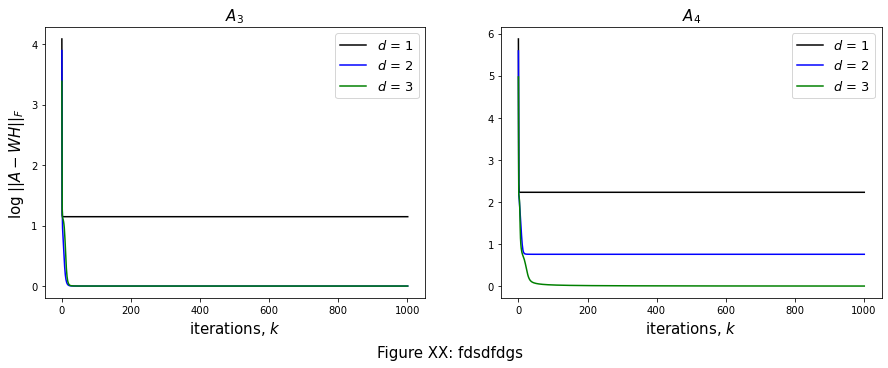

In [7]:
#g

"""
g) For A3 and A4, run the NMF algorithm for d = 1, d = 2 and d = 3 and
plot ∥A − WkHk∥F as a function of number of iterations in two separate plots
(one for A3 and one for A4). Scale the y-axis logarithmically, using for example
plt.semilogy. Is equation (17) satisfied? How do the results depend on d?
"""

maxiter = 1000
d_vals = [1, 2, 3]
A3_error_arrays = []
A4_error_arrays = []
for d in d_vals:
    A3_error_arrays.append(NMF(A3, d, maxiter = maxiter)[2])
    A4_error_arrays.append(NMF(A4, d, maxiter = maxiter)[2])
    
x_vals_list = [[np.linspace(0, maxiter+1, maxiter+1) for i in range(3)] for j in range(2)]
linestyles  = [["black", "blue", "green"] for i in range(2)]
fig_text    = "Figure XX: fdsdfdgs"

plot_function(x_vals_list, [A3_error_arrays, A4_error_arrays], linestyles, fig_size = (15, 5), 
        xlabels = [f"iterations, $k$", f"iterations, $k$"], ylabels = [r"log $||A-WH||_F$", ""],
        fig_text=fig_text, titles = [r"$A_3$", "$A_4$"], labels = [[f"$d$ = {d_vals[i]}" for i in range(3)] for j in range(2)])

From the plots we see that the equation: 

$$\lVert A - W_{k+1}H_{k+1} \rVert_F \leqslant \lVert A - W_kH_k \rVert_F$$ 

seems to be satisfied, at least up to a thousand iterations. For both matrices and all values of $d$ the error rapidly decreases as the number of iterations k increase, for small values of k. When k grows past a certain value, the error starts to remain constant. This is because the algorithm has converged to a global or local minima. Because of the large number of iterations it is likely that the minima is global. We can see that for some of our cases, like $A_3$ with $d=2$, the error converges to 0. Meaning the NMF is a perfect reconstruction of the original matrix.


We have now developed the tools necessary to begin exploring a larger dataset. 

## (TASK 2) Analysing the CryptoPunks dataset <a class="anchor" id="dataset"></a>

We will now turn our attention to a dataset consisting of 10 000 images of size $24\times24$ pixels. They are stored as RGBA images, meaning that each pixel has 4 values; red, green, blue and alpha. Alpha represents the opacity of the images. We will sample $N=500$ of the images. Towards the end of the prosject we will briefly study the effect of decreasing and increasing $N$. We will use a unique but predetermined seed to ensure unique results that won't change by restarting the notebook. 

The load_images function was handed out, but has been modified slightly to pick images before loading them into the notebook. The images are stored as a $24\times24\times4\times N$ numpy array.   

In [8]:
def load_images(N, seed = 4269):
    """
    Loads N random images from cryptopunk dataset. Use the same seed to get the same
    selection each time. 
    Input:
        integer: N, number of images to load
        integer: seed for random sampling
    Output:
        array: faces, (24,24,4,N) numpy array containing images
    """
    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Chose N random image numbers
    M = 10000 # number of images to choose from
    np.random.seed(seed)
    image_number_choice = np.random.choice(np.arange(0, M),N, replace = False)
        
    # Iterate over folders
    for i in range(len(image_number_choice)):
        im_path = f"./imgs/imgs/imgs/{image_number_choice[i]}.png"
        im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
        faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

    return faces

Below is handed-out code for plotting the images we have loaded. It is modified to add numbers to the images. We also define a function that can merge images. This is to get around jupyter notebooks limit of one attachment per markdown cell.

In [9]:
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, figsize = (16, 16), number_color = "black", show = True):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # Initialize subplots
    fig, axes = plt.subplots(nplot, nplot, figsize = figsize)

    # Set background color
    plt.gcf().set_facecolor("lightgrey")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        if nplot > 1:
            axes[i,j].axis('off')
        else:
            axes.axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            if nplot > 1:
                axes[i,j].imshow(scaled_img)
            else:
                axes.imshow(scaled_img)
        else:
            if nplot > 1:
                axes[i,j].imshow(imgs[:,:,:,idx])
            else:
                axes.imshow(imgs[:,:,:])
        
        # Add numbers to each image
        if nplot > 1 and number_color:
            axes[i, j].text(0, 4, f"{idx+1}", color = number_color, fontsize = 20)

    # Tight layout so images will appear closer together
    plt.tight_layout()
    
    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)
    
    if show:
        plt.show()
    else:
        plt.close()

        
def plotimgs_merge(filetitles, merged_title, img_txt = ["a)", "b)", "c)"]):
    """
    Plots images side by side. This lets us combine images and serves as a workaround to 
    jupyters limitation of one image attachment per markdown cell.
    input:
        filetitles: list of titles of images to plot
    """
    num_of_imgs = len(filetitles) # Number of images
    size = 1000 
    font = ImageFont.truetype("arial.ttf", int(50 * size/1000))

    # Load images
    images = [Image.open(filetitle + ".png") for filetitle in filetitles]
    
    # Resize and merge the images
    x_size = int(size*(1+1/20))*num_of_imgs + int(size*(1/20))
    y_size = int(size*(1+3/20)) # double space below for figtext
    
    merged_Image = Image.new('RGB', (x_size, y_size), (250, 250, 250))
    for index, image in enumerate(images):
        # Resize image
        image = image.resize((size, size))
        
        # Place image in merged image
        x_coord = int(size*(1+1/20))*index + int(size*(1/20))
        y_coord = int(size*(2/20))
        merged_Image.paste(image, (x_coord, y_coord))
        
    # Add text above each image:
    draw = ImageDraw.Draw(merged_Image)
    for index, text in enumerate(img_txt):
        x_coord = int(size*(1/20) + size/2) + index*(size*(1+1/20)) - draw.textsize(text, font=font)[0]/2
        y_coord = int(size*(1/20)*1/2)
        draw.text((x_coord, y_coord), text, (0,0,0), font=font)
    
    # Save image
    merged_Image.save(merged_title + ".png","PNG")

**First look at the dataset**

2a) We now have all we need to investigate the dataset.

In [10]:
# Load N = 500 faces and plot the 64 first
faces500 = load_images(500)
# plotimgs(faces500, nplot = 8, filename="2a_punks.png")



<img src=2a_punks.png alt="Drawing" style="width: 500px;"/>

*Figure XX:* The 64 first images loaded with our seed.

We observe that the faces share a lot of features. For instance 1, 6 and 39 have the same hair. The presence of such shared features is a what makes NMF a viable technique for redusing the information necessary to store the dataset. Instead of storing each feature in every image it occurs we can store all the features and the weights of these features for each image.


**Converting the dataset**

To apply NMF we want to turn our (24, 24, 4, 500) array into a $m\times n$ matrix. For this project we only care about the color channels. We will therefore split the RGBA images into a RGB array of shape (24, 24, 3, 500) and a opacity array (24, 24, 1, 500) wich we store for the plotting the reconstructed images after running out algorithm. Below we define a function to split the channels and reshape the RGB array into a $1728\times N$ matrix. We also define a function to reshape a $1728\times N$ back into an RGB array, and optionaly remerge with the opacity.

In [11]:
def split_and_reshape(faces):
    #input: 24x24x4xN array of stored images
    #output: 1728xN array of with rgb values for the images without opacity, 24x24x500 array of opacity for images 
    faces_opacity = faces[:,:,3,:]
    faces_rgb = faces[:,:,:3,:]
    shape = faces_rgb.shape
    
    # Clever reshape "trick". This is the matrix we will apply the NMF to
    N = faces.shape[-1]
    faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
    
    return faces_reshaped, faces_opacity

def merge_and_reshape(reshaped, opacity = np.array([])):
    #input: 1728xN array of with rgb values for the images without opacity, 24x24xN array of opacity for images 
    #output: 24x24x4xN array of images
    N = int(reshaped.size/1728)
    faces = np.reshape(reshaped, (24,24,3,N))
    if opacity.size > 0:
        opacity = np.reshape(opacity, (24,24,1,N))
        faces = np.concatenate((faces, opacity), axis=2)
    
    faces = np.where(faces<=1, faces, 1)
    
    return faces

# We reshape the faces with our function
faces500_reshaped, opacity500 = split_and_reshape(faces500)

**The *average* face and the rank of A**

2b) 

In [12]:
## The mean face
# Find and plot the average face
mean_face = np.mean(faces500, axis = -1)
# plotimgs(mean_face, 1, filename="2b_meanface.png", figsize = (3, 3))

# Setter fargen til hvit hvis opacity er 0. 
mean_face[:,:,0] = mean_face[:, :, 3] == 0
mean_face[:,:,1] = mean_face[:, :, 3] == 0
mean_face[:,:,2] = mean_face[:, :, 3] == 0 

num_opacity = np.sum(mean_face[:, :, 3]==0)
mean_face[:, :, 3] = 1

# plotimgs(mean_face, 1, filename="2b_0avg.png", figsize = (3, 3)) # hvit betyr her gjennomsnitt lik 0

# Merge the images
# plotimgs_merge(["2b_meanface", "2b_0avg"], f"2b_merged_img", ["Average face", "Non-zero pixels"])

print(f"The number of pixels with zero opacity = {num_opacity}\n")
print(f"np.linalg.matrix_rank gives rank = {np.linalg.matrix_rank(faces500_reshaped)}\n")
print(f"np.linalg.svd gives rank = {np.sum(np.abs(np.linalg.svd(faces500_reshaped)[1]) > 1.0e-13)}\n")

The number of pixels with zero opacity = 166

np.linalg.matrix_rank gives rank = 377

np.linalg.svd gives rank = 377




2b) 

<img src=2b_merged_img.png alt="Drawing" style="width: 500px;"/>

*Figure XX:*

Averaging over every color channel for every pixel, we get the image on the left above. The distinct features of the above image yields much useful information about the dataset. Consider, for example, the very dark and clear and dark boundary of the face. This being an average image, we would expect the majority of the dataset having a face-boundary on or close to this one. The same can be said for the position of the eyes and the shape and placement of the mouth.  

Averaging over the opacity channel as well, and creating an image with white pixels where the average opacity is zero, yields the image on the right. As it turns out, 166 of the 24x24 = 576 pixels on every image has an opacity of zero. This implies that at least 3x166=498 rows (one for each color channel) are reduntant or zero, as an opacity equal to zero practically makes the color transparent. Additionally, it puts an upper bound for the rank of the matrix, as these 498 rows would be linearly dependant on the other rows, giving 1728-498=1330 as an upper bound for the rank of the matrix. Being almost three times $N=500$, the upper bound is quite useless.

**NMF with $d=64$**

2c)

***c) Calculate the NMF of the 3 color channels as explained above using d = 64. Plot
the columns of W interpreted as RGB images (each columns should be a 24×24×3
vector so you can use the handed out plotting function after reshaping). Explain
and discuss what you see. Does the NMF capture the important features of the
dataset? You can also try with different values for d to see how this affects the
results.***

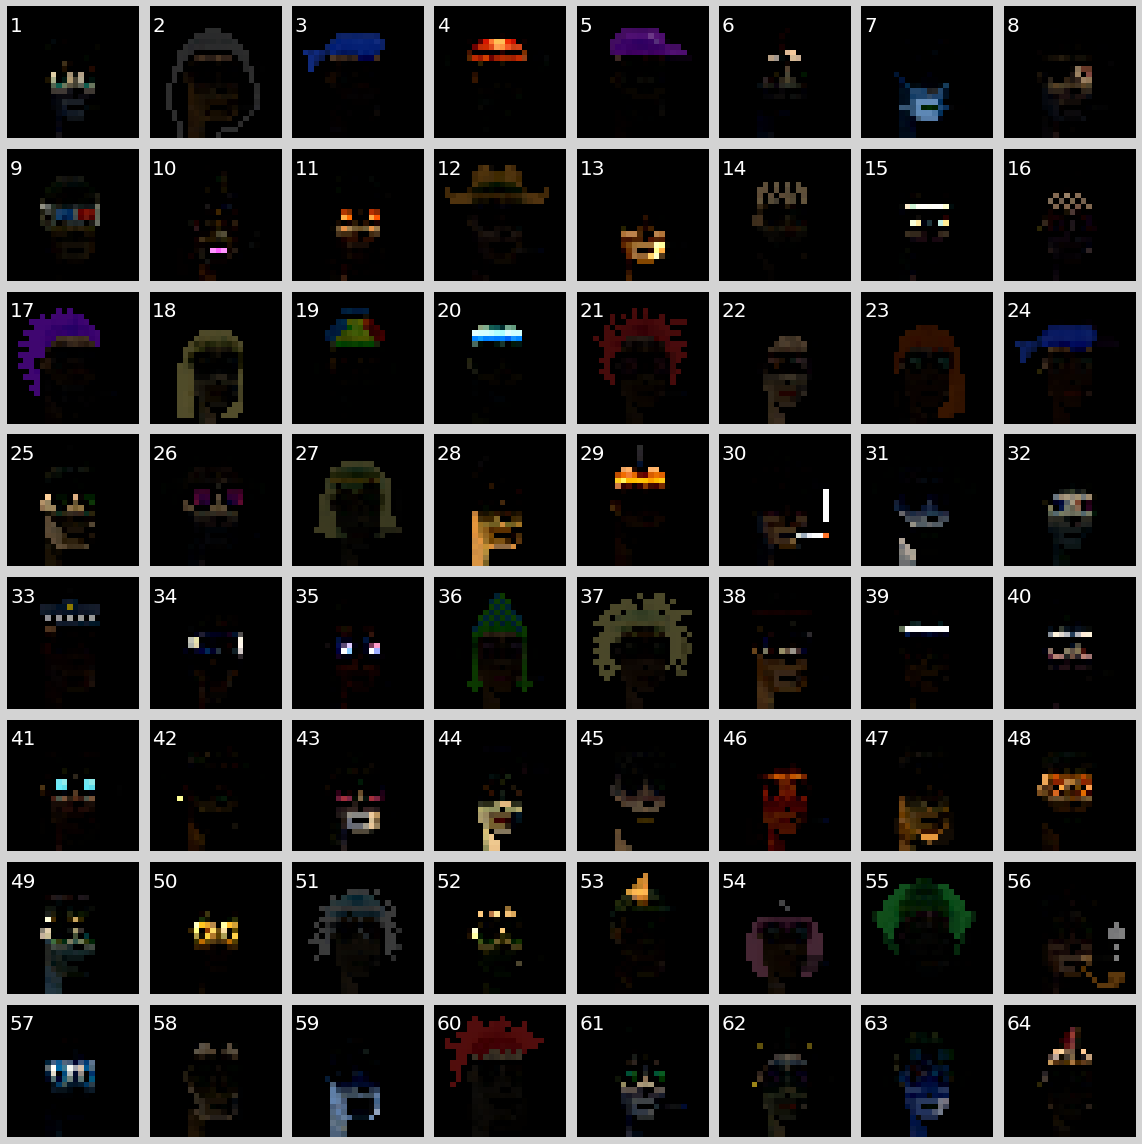

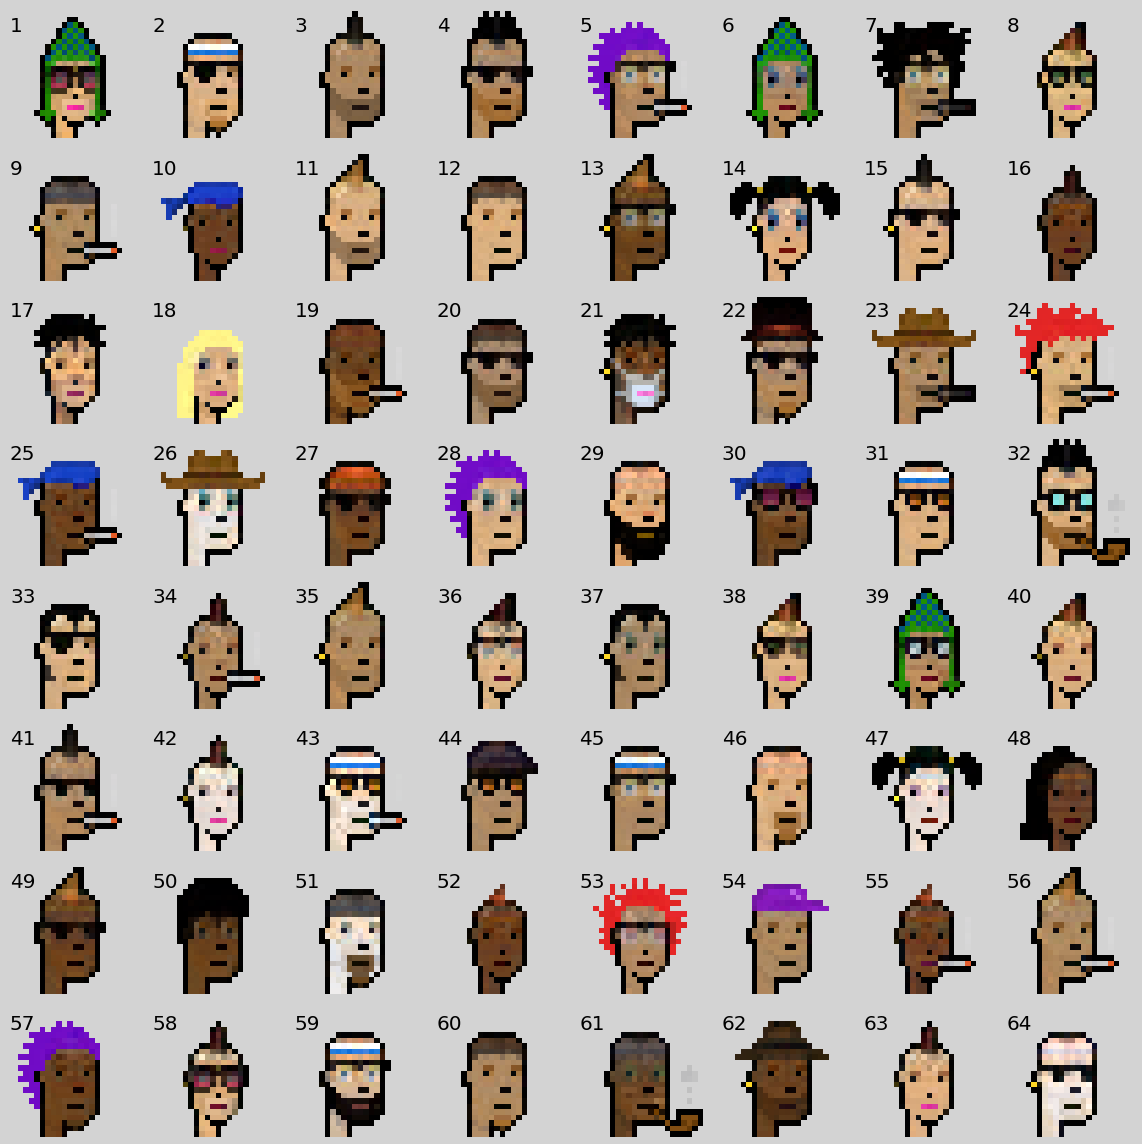

FileNotFoundError: [Errno 2] No such file or directory: '2a_punks.png'

In [20]:
#2c, 2d

def reconstruction_images(d, maxiter = 1000, N = 500, basis_color = False, faces_to_plot=8, show=True, brightness = 1):
    # Load and Reshape
    faces_reshaped_d, opacity_d = split_and_reshape(load_images(N))
    
    # Perform NMF algorithm
    W_d, H_d, err_d = NMF(faces_reshaped_d, d, maxiter = maxiter)
    
    # Reshape and plot basis
    if d > 1:
        W_columns_d = merge_and_reshape(W_d*brightness) # Any scaling of W is valid as we can scale H by 1/brightness 
        plotimgs(W_columns_d, int(d**(1/2)), filename=f"punks_basis_d{d}.png", number_color = basis_color, show=show)

    # Reshape and plot faces
    img_reconstructed_d = merge_and_reshape(np.dot(W_d, H_d), opacity_d)
    plotimgs(img_reconstructed_d, faces_to_plot, filename=f"{faces_to_plot**2}punks_d{d}.png", show=show)
    
## Reconstruction and basis for different d
# n = 4
# d_vals = {16, 64, 144}
# for d in d_vals:
#     reconstruction_images(d, faces_to_plot=n, show=False, brightness = 1.5)

# plotimgs_merge([f"punks_basis_d{d}" for d in d_vals], "basises",               img_txt = [f"d = {d}" for d in d_vals])
# plotimgs_merge([f"{n**2}punks_d{d}" for d in d_vals], f"multiple_{n**2}punks", img_txt = [f"d = {d}" for d in d_vals])

# # Basis and reconstruction
# reconstruction_images(8**2, basis_color = "white")
# plotimgs_merge([f"{8**2}punks_d{8**2}", "2a_punks"], "2d_reconstruction_comparison", ["Reconstruction", "Original"]) 

2c) important features


The code above ...

<img src=punks_basis_d64.png alt="Drawing" style="width: 500px;"/>

*Figure XX:* gggggggggg





We also tried different values for $d$:


<img src=basises.png alt="Drawing" style="width: 1000px;"/>



2d) 

***d) With d = 64, calculate the 64 reconstructions W H corresponding to the images
you plotted in 2a) and plot the reconstructions (again, you can use the handed out
plotting function after reshaping). Are the reconstructions overall good? How do
the reconstructions deviate from the original images (if they deviate at all)? In
particular, are all features of the images equally well reconstructed?***


**Reconstructing the dataset**

<a class="anchor" id="2d_reconstruction_comparison"></a>

<img src=2d_reconstruction_comparison.png alt="Drawing" style="width: 1000px;"/>


*Figure XX:* ifjesjfn $d = 64$. Later we will compare these reconstructions to [noisy reconstructions](#3d_reconstruction_comparison).



Discuss deviation







Other values for d ...



<img src=multiple_16punks.png alt="Drawing" style="width: 1000px;"/>



**Convergence**

2e) 

***e) For each iteration k, calculate ∥A−WkHk∥F and plot it as a function of iterations
similarily to what you did in Task 1, but now for d = 16, 32, 64. Are the results
reasonable? Does it look like the algorithm has converged?***

When considering the error of the reconstructions we want a number that doesn't depend on the number of images $N$. 
We want a measure of the error per image. The division by $\sqrt{N}$ solves this:

$$
\begin{align}
    ||A_{M\times N}||_F = \sqrt{\sum_j^N{\sum_i^M{a_{i,j}^2}}} 
                        = \sqrt{\sum_j^N{{||\vec a_{j}||_F^2}}} 
                        = \sqrt{N\cdot \overline {{||\vec a||_F^2}}} 
                        = \sqrt{N}\sqrt{\cdot \overline {{||\vec a||_F^2}}}
                        = \sqrt{N}\cdot ||\vec a||_{F, \textrm{RMS}}.
\end{align}
$$



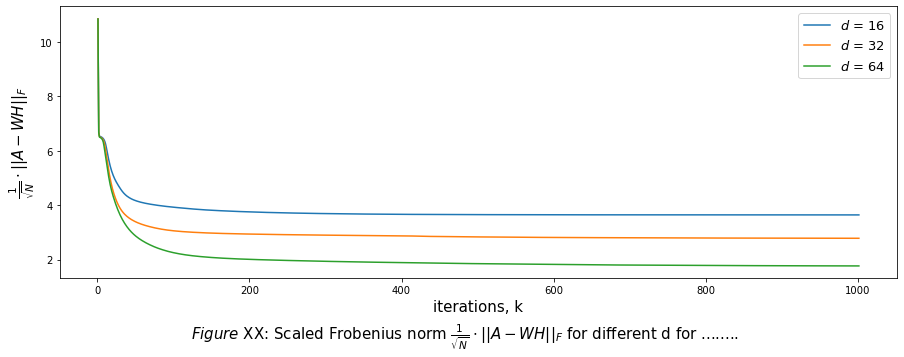

In [14]:
#2e) 

def error_sim(faces_reshaped, maxiter=1000, d_vals=[16, 32, 64], N=500):
    image_error_arrays = []
    for d in tqdm(d_vals, leave = False):
        image_error_arrays.append(NMF(faces_reshaped, d, maxiter=maxiter)[2]/np.sqrt(N)) # øke maxiter
    
    txt = r"$Figure$ XX: Scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$ for different d for ........"
    plot_function([[np.arange(1, maxiter+2) for d in d_vals]], [image_error_arrays], [["tab:blue", "tab:orange", "tab:green"]], 
        fig_size=(15, 5), xlabels=["iterations, k"], ylabels=[r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$"],#r'$||\vec{a}-W\vec{h}||_{F, \mathrm{RMS}}$']
        fig_text=txt, labels = [[f"$d$ = {d}" for d in d_vals]])

error_sim(faces500_reshaped, maxiter = 1000)

2e) discuss



**2f) Reconstruction error and feature number $d$**

We will now do NMF calculation for a wide range of $d$ to investigate how the reconstruction error, $\lvert\lvert A - WH \rvert\rvert_F$. We expect that the error is reduced as we capture more features in matrix $W$. 
\
\
\
\
\
\
\
\
\

***f) For a wide range of d, for example d = 16, 64, 128, 256, do an NMF and calculate
∥A−W H∥F
9
. Make sure you are using a high number of maximum iterations (at
least 1000 iterations), and if your computing resources and time allows it, try to
use more values for d. Plot this quantity as a function of d. Discuss the resulting
plot. Specifically, how would you expect ∥A − W H∥F to depend on d?***


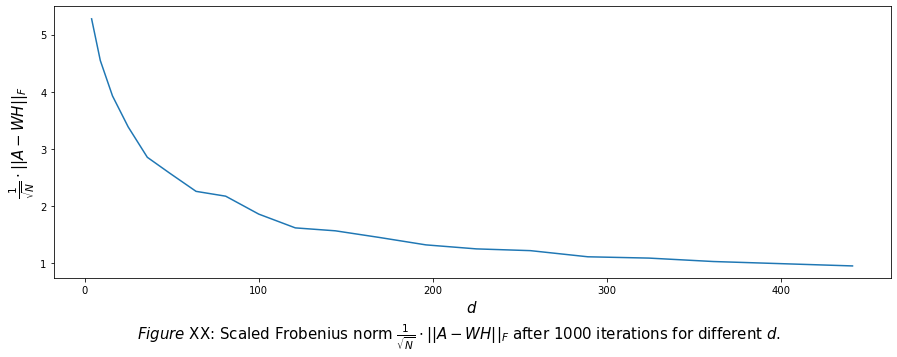

In [15]:
#2f)

def final_error_sim(d_vals, N = 500, maxiter = 1000, noise_level = 0, data_title = False):
    
    # Load, reshape and add noise to images
    faces_es          = load_images(N)
    faces_reshaped_es = split_and_reshape(faces_es)[0]
    faces_r_noisy_es  = split_and_reshape(faces_es)[0] # We need faces_reshaped_es for error comparison
    
    # We add this possibility to reuse the function later. 
    if noise_level != 0:
        faces_r_noisy_es = add_noise(faces_reshaped_es, noise_level)
    
    # Initialise arrays for final errors
    final_error_es = np.zeros(len(d_vals))

    # We do the simulation for all the d values
    for i in tqdm(range(len(d_vals)), leave = False):
        W_es, H_es, err_es = NMF(faces_r_noisy_es, d_vals[i], maxiter = maxiter)
        final_error_es[i]  = np.linalg.norm(faces_reshaped_es - np.dot(W_es, H_es), 'fro')
    
    ## SAVE DATA
    if data_title:
        np.savez(data_title, d_vals=d_vals, final_error = final_error_es)
        
    return final_error
    
# To run this cell uncomment the line below. Warning: run at own risk. Reduce some parametres to reduce rumtime.
# ###final_error = final_error_sim([i**2 for i in range(2, 22)], maxiter = 1000), data_title = "###2f.npz")

# Load data from commented line and make plot
data = np.load("2f.npz")

txt = r"$Figure$ XX: Scaled Frobenius norm $\frac{1}{\sqrt{N}}\cdot||A-WH||_F$ after 1000 iterations for different $d$."
plot_function([[data['d_vals']]], [[data['final_error']/np.sqrt(500)]], [["tab:blue"]], 
        fig_size=(15, 5), xlabels=[r"$d$"], ylabels=[r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$"],
        fig_text=txt)


2f)
As figure FROBENIOUSNORMBOI shows, the frobenius difference between $A$ and $WH$ is a decreasing function of $d$. 

To get zero error, $W$ and $H$ must be tuned so that $WH$ is exactly equal to $A$. For $d < \frac{mn}{m+n}$, the total number of elements in $W$ and $H$ combined is less than the total number of elements in $A$, meaning $A$ can be reproduced exactly using fewer elements than it originally had. 

Using the theory of Singular Value Decomposition, we know that $A$ can be decomposed into a product of three matrices $A = U\Sigma V^T$, or equivalently the two matrices $U$ and $\Sigma V^T$. If some of the singular values are zero, the rightmost columns of $U^T$ would be redundant, as they're multiplied by zero in the matrix product $\Sigma V^T$. 

It can be shown that the best approximation to a matrix $A$ with lower rank than $A$ itself is the truncated SVD REFFFFF. In general, SVD cannot be characterized as a NMF because of the "Non-negative" critera (The singular values and the elements in $U$ and $V$ need not be positive). However, if every element produced by the SVD happened to be positive, it would correspond to a Non-negative matrix factorization (multiply either $U$ or $V$ by $\Sigma$). For a given matrix of rank $n$ then, to be able to approximate the matrix as well as the truncated SVD of rank $d^\prime \leq n$, the corresponding value of $d$ would need to be at least $d^\prime$. Therefore, the smallest $d$ that could (theoretically) yield a perfect NMF of a matrix $A$ is the number of nonzero elements in the SVD of $A$. 

If our algorithm always produced the global minimum, the following theorem shows that the frobenious norm must decrease when increasing $d$.

**Theorem:**
Given $A \in \mathbb{R}^{m\times n}$. Let $W \in \mathbb{R}^{m\times d}$ and $H \in \mathbb{R}^{d\times n}$ be a solution to the optimization problem

$$
    \min_{W, H} ||A-WH||_F, \, \textrm{s.t} \, W,H \, \textrm{non-negative}
$$

Furthermore, let $W' \in \mathbb{R}^{m\times d+1}$ and $H' \in \mathbb{R}^{d+1\times n}$  be a solution to the optimization problem

$$
    \min_{W', H'} ||A-W'H'||_F, \, \textrm{s.t} \, W',H' \, \textrm{non-negative}
$$

then 
$$
    \lVert A - W'H'\rVert _F \leq \lVert A - WH\rVert _F
$$
With equality only when $WH=A$

**Proof:**

We first prove that not every element in $WH$ can be larger than the the corresponding element in $A$. Suppose $Z = WH$ is the solution to the optimization problem 
$$
    \min_{W, H} ||A-WH||_F, \, \textrm{s.t} \, W,H \, \textrm{non-negative}
$$

And assume $a_{ij} \leq z_{ij} \, \forall i, j$. Let $$\varepsilon \equiv \frac{1}{mn}\sum_{i, j}(z_{i, j} - a_{i, j}) \geq 0$$
Where the last inequality follows from the assumption. Consider now the matrix $Z'$ given by $z_{ij}' = z_{ij} - \varepsilon$. This has the frobenious norm:

$$
\begin{align}
    \lVert A - Z'\rVert _F^2 &= \sum_{i, j} (a_{ij}-z_{ij})^2 
                             = \sum_{i, j} a_{ij}^2 -2 \sum_{i, j} z_{ij}a_{ij} + \sum_{i, j} z_{ij}^2 
                             = \sum_{i, j} a_{ij}^2 -2 \sum_{i, j} (z_{ij}-\varepsilon)a_{ij} + \sum_{i, j} (z_{ij}-\varepsilon)^2 \\
                             &= \sum_{i, j} a_{ij}^2 -2 \sum_{i, j} z_{ij}a_{ij} + 2 \sum_{i, j} \varepsilon a_{ij} + \sum_{i, j} z_{ij}^2 - 2\sum_{ij}z_{ij}\varepsilon + \sum_{ij} \varepsilon^2 \\
                             &= \lVert A - Z\rVert _F^2 + 2 \sum_{i, j} \varepsilon a_{ij} - 2 \sum_{ij}z_{ij}\varepsilon + \sum_{i, j} \varepsilon^2 
                             = \lVert A - Z\rVert _F^2 + 2\varepsilon \sum_{i, j} (a_{ij} - z_{ij}) + mn\varepsilon^2 \\
                             &= \lVert A - Z\rVert _F^2 + 2\varepsilon (-mn\varepsilon) + mn\varepsilon^2
                             = \lVert A - Z\rVert _F^2 -mn\varepsilon^2 \leq \lVert A - Z\rVert _F^2
\end{align}
$$

This tells us that any reconstruction $W$ of $A$ must either be perfect with $\varepsilon = 0$ or there exists at least one pair of numbers $i, j$ such that $z_{ij} < a_{ij}$. 

Create the matrices $W'$ and $H'$ by adding a column full of zeros to $W$ and a row full of zeros to $H$. The key insight is that $WH = W'H'$

$$
    (W'H')_{ij} = \sum_{k=1}^d w_{ik}h_{kj} = \sum_{k=1}^{d-1} w_{ik}h_{kj} + w_{id}h_{dj} = (WH)_{ij} + W_{id}' H_{dj}'.
$$

Where $W_{id}'=H_{dj}' = 0$. We've shown that $A_{ij}-(WH)_{ij} > 0$ for at least one pair of i, j (as long as $WH \neq A$). We can therefore choose

$W_{id}'=H_{dj}'=\sqrt{A_{ij}-(WH)_{ij}}$, yielding  $$(W'H')_{ij}=(WH)_{ij} + W_{id}' H_{dj}=(WH)_{ij} + A_{ij}-(WH)_{ij} = A_{ij}.$$

The frobenious error in the new matrix would therefore decrease. This means that increasing d will always make it possible to decrease the total frobenious difference between $A$ and $WH$ as long as $WH \neq A$. By the discussion in REFHEROGSÅTILTRONDHISTOGRAM, the algorithm reaches roughly the same minimum for many simulations, indicating that the algorithm reaches a value almost equal to the global minima.

**Global and local minima**

Before moving on to denoising we do a final simulation to see if we hit
\

\\
\
\

SKAL VI KJØRE 1000 seeds??

\
\
\
\



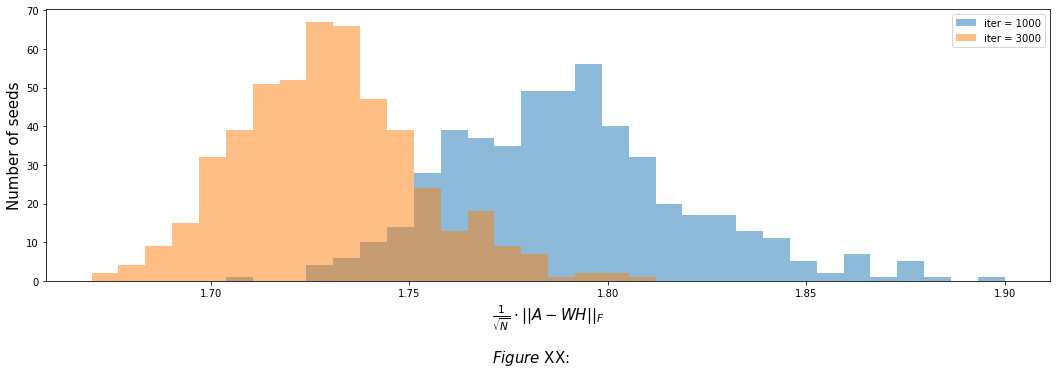

In [16]:
## KUNNE vi brukt en bedre seed??

def seed_test(number_of_seeds, maxiter = 1000, d = 64, N = 500, seed = 4269, data_title = "seed_test"):
    # Load and split faces
    faces_reshaped_s = split_and_reshape(load_images(N))[0] # index 1 is the opacity channel
    
    # Prepare array of seeds
    np.random.seed(seed)
    seeds = np.random.choice(range(number_of_seeds*10), number_of_seeds, replace = False)
    
    # Initialise list to store the different reconstructions errors
    reconstruction_errors = []
    
    # Do NMF simulation and append reconstruction for each seed
    for i in tqdm(range(number_of_seeds)):
        W_s, H_s, err_s = NMF(faces_reshaped_s, d, maxiter = maxiter, seed = seeds[i])
        reconstruction_errors.append(err_s[-1])
    
    # Save the data
    
    np.savez(data_title, seeds = seeds, reconstruction_errors = reconstruction_errors)

n        = 500
iter_arr = [1000, 3000]
## Do seed tests
# for i in iter_arr:
#     ###seed_test(n, maxiter = i, data_title = f"###{n}seeds_{i}iter.npz")

## Plot histogram
fig, ax = plt.subplots(figsize = (18, 5))
bins = np.linspace(1.67, 1.90, 35)
for i in iter_arr:
    reconstruction_errors = np.load(f"{n}seeds_{i}iter.npz")["reconstruction_errors"]
#     print(min(reconstruction_errors)/np.sqrt(500), max(reconstruction_errors)/np.sqrt(500))
    ax.hist(reconstruction_errors/np.sqrt(500), bins, alpha = 0.5, label = f"iter = {i}")
ax.legend(loc = "upper right")
ax.set_xlabel(r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$", fontsize = 15)
ax.set_ylabel("Number of seeds", fontsize = 15)
plt.figtext(0.5, -0.1, r"$Figure$ XX: ", wrap=True, horizontalalignment='center', fontsize = 15)

plt.show()

## (Task 3) Denoising <a class="anchor" id="denoising"></a>

We will now add noise ...

We model the noise as:

$$A_{\textrm{noisy}} = A + \sigma E,$$

where $\sigma > 0 $ is our *noise level*, and $E$ sampled from $\mathcal{N}(0, 1)$. Below is the handed out function to add noise to the images.

In [17]:
def add_noise(imgs_reshaped, sigma = 0.1, seed = 4269):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = imgs_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    np.random.seed(seed)
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

***Vi kan nå legge til støy til bildene våre, legge på opasitetskanalaen igjen og plotte. Dere må gjøre noe lignende etter dere har anvendt NMF og ønsker å plotte rekonstruksjoner med opasitet.***

3a)\ 
\
\
\
\
\



In [18]:
# Add noise to images
faces500_reshaped_noisy = add_noise(faces500_reshaped, sigma = 0.1)

# Calculate the error of the noisy images
noise500_error = np.linalg.norm(faces500_reshaped_noisy - faces500_reshaped, 'fro') 
print(noise500_error)

# For plotting noisy images we add the opacity
# faces500_noisy = merge_and_reshape(faces500_reshaped_noisy, opacity500)
# plotimgs(faces500_noisy, filename = "3a_noisy_punks.png")

42.13420072456912


<img src=3a_noisy_punks.png alt="Drawing" style="width: 500px;"/>

**NMF -> ADD COOLER TITLEs**

3b) 

***• b) Using the same approach as task 2, fit an NMF using d = 64 to the noisy images.
Plot the columns of W and the reconstructions like you did in 2c) and 2d). Are
the reconstructions less noisy than the noisy images? Compare the columns of W
and the reconstructions to the results you got in task 2.***

In [ ]:
d = 64
W_noisy, H_noisy, err_noisy = NMF(faces500_reshaped_noisy, d, maxiter = 1000) # øke maxiter!!
print(noise500_error/np.sqrt(500))
print(np.linalg.norm(np.dot(W_noisy,H_noisy) - faces500_reshaped, 'fro')/np.sqrt(500))

# brightness = 1.5
# W_columns_noisy = merge_and_reshape(brightness*W_noisy)
# plotimgs(W_columns_noisy, 8, filename="3b_punks_basis_noisy.png", figsize = (12, 12), number_color = "white")
# plotimgs_merge(["3b_punks_basis_noisy", f"punks_basis_d{64}"], "3b_basis_comparison", [f"\u03C3 = 0.1", "\u03C3 = 0"]) 

# images_noisy_reborn = merge_and_reshape(np.dot(W_noisy, H_noisy), opacity500)
# plotimgs(images_noisy_reborn, 8, filename="3b_noisy_reconstructions.png", figsize = (12, 12))
# plotimgs_merge([f"3b_noisy_reconstructions", "3a_noisy_punks"], "3b_recoonstruction_comparison", 
#                ["Reconstruction", "Noisy faces"]) 

We first look at the columns of $W$:

<img src=3b_basis_comparison.png alt="Drawing" style="width: 1000px;"/>





<a class="anchor" id="3d_reconstruction_comparison"></a>

<img src=3b_recoonstruction_comparison.png alt="Drawing" style="width: 1000px;"/>

[noiseless reconstructions](#2d_reconstruction_comparison)

[]


3c) 

***c) As you did in task 2, fit an NMF to the noisy images for a wide range of d,
calculate the reconstruction error ∥A − W H∥F (important: A is here the original
images, NOT the noisy images). Plot this with the error you calculated in 2f),
where noiseless images were used. If you have a large enough range of d and large
enough noise you should see that the reconstruction error for the noisy images
is somewhere between ”U”-shaped and ”L”-shaped, and at some point the error
should increase for large enough d. Explain why the plot looks like this (try to
include the words ”underfitting” and ”overfitting”). Approximately, what value of
d is the ”best fit”, that provides the lowest reconstruction error?***

For an $m\times n$-matrix we want to choose a value for d such that the total information is reduced:

$$
\begin{align}
mn &< md+dn \\
d &< \frac{mn}{m+n}. 
\end{align}
$$


In [ ]:
# BIG SIMULATION TIME


def denoise_at_different_N_sim(N_vals, maxiter, noise_level, number_of_d, filetitle = "denoise_at_diff_N.npz"):
    """
    
    """
    
    # Initialize arrays for data storage
    d_val_arrays         = []
    final_errors         = []
    final_errors_noisy   = []
    initial_noise_errors = []
    
    for N in tqdm(N_vals):
        # We consider only d values that reduce the amount of data
        d_vals = np.linspace(64, np.floor(1728*N/(1728+N)), number_of_d, dtype = 'int')

        # Load, reshape and add noise to images
        faces_es                = load_images(N)
        faces_reshaped_es       = split_and_reshape(faces_es)[0] # only want color channels
        faces_reshaped_noisy_es = add_noise(faces_reshaped_es, noise_level)
        
        print(np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'fro')/N**(1/2))      
        print(np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'nuc')/N**(1/2))      
        
        # Initialise arrays for final errors
        final_error_es       = np.zeros(len(d_vals))
        final_error_noisy_es = np.zeros(len(d_vals))
    
        # Do NMF for all the d values
        for i in tqdm(range(len(d_vals)), leave = False):
            # NMF with noise removal
            W_n, H_n, err_n         = NMF(faces_reshaped_noisy_es, d_vals[i], maxiter = maxiter)
            final_error_noisy_es[i] = np.linalg.norm(faces_reshaped_es - np.dot(W_n, H_n), 'fro')

            # NMF without noise removal
            W, H, err         = NMF(faces_reshaped_es, d_vals[i], maxiter = maxiter)    
            final_error_es[i] = err[-1]
        
        # Add the errors to the final_errors
        d_val_arrays.append(d_vals)
        final_errors.append(final_error_es)
        final_errors_noisy.append(final_error_noisy_es)
        initial_noise_errors.append(np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'fro'))        
    
    # Save the data
    np.savez(filetitle, N_vals = N_vals, maxiter = maxiter, noise_level = noise_level, d_val_arrays=d_val_arrays, 
             final_errors = final_errors, final_errors_noisy = final_errors_noisy, initial_noise_errors = initial_noise_errors)
    
# We load N images, with N chosen from this array
N_vals      = [250, 500, 750, 1000]
maxiter     = 1000
noise_level = 0.1
number_of_d = 100

# Run the simulation at own risk, remove the overwrite protection "###"
# ###denoise_at_different_N_sim(N_vals, maxiter, noise_level, number_of_d, filetitle = "###denoise_at_diff_N.npz")

data = np.load("denoise_at_diff_N.npz")
d_val_arrays       = data['d_val_arrays']
final_errors       = data['final_errors']
final_errors_noisy = data['final_errors_noisy']
initial_noise_errors = data['initial_noise_errors']

for i in range(4):
    final_errors[i] /= N_vals[i]**(1/2)
    final_errors_noisy[i] /= N_vals[i]**(1/2)
    initial_noise_errors[i] /= N_vals[i]**(1/2)

x_vals_list = [[d_val_arrays[i], d_val_arrays[i],       [d_val_arrays[i][0],      d_val_arrays[i][-1]]]     for i in range(4)]
y_vals_list = [[final_errors[i], final_errors_noisy[i], [initial_noise_errors[i], initial_noise_errors[i]]] for i in range(4)]
linestyles  = [["g", "b", "b--"] for i in range(4)]
fig_text    = f"$Figure$ XX: fdsdfdgs"

plot_function(x_vals_list, y_vals_list, linestyles, fig_size = (15, 10), shape = (2, 2),
        xlabels = ["", "", f"$d$", f"$d$"], ylabels = [r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$", "", r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$", ""],
        fig_text=fig_text, fig_text_size = 15, fig_text_y = 0.04, 
        title_size = 15, titles = [f"$N=${N}" for N in N_vals], 
        label_size = 15, labels = [False, [r"$\sigma=0$", r"$\sigma=0.1$", "Noise error"], False, False],
        loc = [False, "lower left", False, False])





We will now do a sligthly different experiment with the noisy images. If we had done the same analysis as previously, the difference between the noisy A, $A_n$, and the NMF, $WH$, would decrease as in FIGUREERROR. Comparing the NMF with the original matrix $A$, however, we will (hopefully) find NMF's that are closer to $A$ than the original noisy matrix. This would mean that the details the NMF 'loses' for smaller values of d actually corresponds to the noise, resulting in denoised images.

In [ ]:
def denoise_at_different_noise_lvl_sim(noise_levels, maxiter, d_vals, N = 500, filetitle = "denoise_at_diff_noise.npz"):
    """
    
    """

    # Load and reshape N images 
    faces_es          = load_images(N)
    faces_reshaped_es = split_and_reshape(faces_es)[0]
    
    # Initialize lists for errors
    final_errors_noisy   = []
    initial_noise_errors = []
    
    # Do NMF for each noise level
    for noise_level in tqdm(noise_levels, leave=False):
        # Add noise to images
        faces_reshaped_noisy_es = add_noise(faces_reshaped_es, noise_level)

        # Initialise arrays for final errors
        final_err = np.zeros(len(d_vals))

        # Do NMF algorithm for each d-value
        for index, d_val in tqdm(enumerate((d_vals)), total = len(d_vals), leave=False):
            W, H, err    = NMF(faces_reshaped_noisy_es, d_val, maxiter = maxiter)
            final_err[index] = np.linalg.norm(faces_reshaped_es - np.dot(W, H), 'fro')

        # Add values
        final_errors_noisy.append(final_err)
        initial_noise_err = np.linalg.norm(faces_reshaped_noisy_es - faces_reshaped_es, 'fro')
        initial_noise_errors.append(initial_noise_err)
        
        # Save and plot 
        np.savez(f"denoise_at_sigma={noise_level}", N=N, maxiter=maxiter, noise_level=noise_level, d_vals=d_vals, 
                 final_err = final_err, initial_noise_err = initial_noise_err)
        plt.plot(d_vals, final_err)
        plt.axhline(y=initial_noise_err)
        plt.show()

        
    # SAVE DATA
    np.savez(filetitle, N=N, maxiter=maxiter, noise_levels=noise_levels, d_vals=d_vals, 
             final_errors_noisy = final_errors_noisy, initial_noise_errors = initial_noise_errors)
    
# Set parametres

######## ØKES TIL maxiter 1000, 100? dvals

noise_levels = [0, 0.05, 0.1, 0.2]
maxiter      = 1000
d_vals       = np.linspace(64, 1000, 100, dtype = 'int')

# Do simulation at own risk
# ###denoise_at_different_noise_lvl_sim(noise_levels, maxiter, d_vals, N = 500, filetitle = "###denoise_at_diff_noise.npz")
    
# Load data
data = np.load("denoise_at_diff_noise.npz")
        
x_vals_list = [data['d_vals'] for noise in noise_levels]
y_vals_list = [data['final_errors_noisy'][i]/np.sqrt(500) for i in range(len(noise_levels))]
labels      = []
for i, noise_level in enumerate(noise_levels):
    x_vals_list.append([data['d_vals'][0],                            data['d_vals'][-1]])
    y_vals_list.append([data['initial_noise_errors'][i]/np.sqrt(500), data['initial_noise_errors'][i]/np.sqrt(500)])

    
linestyles  = [["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:blue--", "tab:orange--", "tab:green--", "tab:purple--"]]
linestyles  = [["b", "r", "c", "y", "b--", "r--", "c--", "y--"]]

fig_text    = "Figure XX: fdsdfdgs"

plot_function([x_vals_list], [y_vals_list], linestyles, fig_size = (9, 5),
        xlabels = [f"$d$"], ylabels = [r"$\frac{1}{\sqrt{N}}\cdot||A-WH||_F$"],
        fig_text=fig_text, fig_text_y = -0.04, labels = [[r"$\sigma=0$", r"$\sigma=0.1$", "Noise error"]],
        loc = [False, "lower left", False, False])




***TODO: At what d is error lowest***



This simulation for different values of noise (characterized by the value $\sigma$), can be seen in FIGUREFARGEHELVETE. The horizontal dotted lines are the frobenius differences between the original matrix and the different noisy matrices.

Why the algorithm works, and why the graphs are shaped the way they are can, at least partially, be explained with the terms underfitting and overfitting. The phenomena of underfitting and overfitting are major concerns in the field of machine learning, and can be explained with a classic example from machine learning. Say you would like to make an algorithm that can recognize handwritten digits. To do this, you can use a neural network combined with a very large dataset. The neural network works as a function approximator, that approximates the function image -> digit using the dataset. 

Underfitting happens when the dataset or the number of training epochs over the dataset is too small. With too little information, the neural network cannot approximate the real (and rather complex) function of digit recognition, as the nuances of the problem hasn't manifested themselves yet. This is like trying to discern a non-linear relationship between two parameters, having only two datapoints. Too little information results in a function approximation of a simpler function, leading to large errors.

Overfitting on the other hand, happens when the neural network trains too much on the same dataset. The function approximation will then begin to take into account the individual aspects of the images, rather than the general notion of what a digit is. The neural network would be able to predict almost perfectly which numbers the dataset corresponds to, but has now learned features of numbers that are specific to the dataset, and not features of general numbers. This, too, results in large errors.

When the above algorithm reconstructs the noisy images with a low value of d, the drastically smaller amount of information leads to underfitting, with corresponding large errors. Underfitting is even more predominant than the noise itself, as can be seen by comparing the values on the graph towards the left with the horizontal lines. It is therefore necessary to increase the d to get a good reconstruction of A. 

Too large a value of d will, however, result in columns of $W$ corresponding to features specific to the noisy images, rather than general features of faces. The noisy images does still have features like 'eye placement' and'hair color', but they will also have features originating from the added noise. The clue, then, is to increase the value of d until the features in $W$ corresponds to general features of the faces, and stop before the features that are specific to the noisy dataset (i.e. the noise) are added. 

These effects results in large errors for small d, and large errors for large d. It makes sense therefore, that the graph has a critical value of d with the smallest frobenius-difference with the noiseless image A.

## Conclusion <a class="anchor" id="conclusion"></a>

3d) 

***d) Include a suitable conclusion to the entire project. What did you find? What
are the advantages and disadvantages of applying NMF for images, in particular
for denoising?***



We've shown that the CryptoPunk dataset is highly, in lack of a better term, 'featurized' in the sense that almost every image can be viewed as a linear combination of specific features. Consider, as an example, IMAGENR of the blue haired guy with reading glasses that have a smoke in his mouth. This image can be written as a mere additive combination of these features. If the position of the eyes or the relative position of the head changed from image to image, this linear combination wouldn't work. The images being centered and the eyes appearing in the same pixel-positions are therefore very important if NMF is going to work. As a result of this, NMF is not the approach one should take when solving a unlinear problem like handwriting recognition. With linear problems, however, the approach has shown itself to be powerful and effective. 

One major advantage of imposing Non-negativity to the standard SVD optimization problem, is the ability for humans to analyze and understand the workings of the algorithm in a graphical way. Non-negativity makes it possible to interpret the matrices (or rather the columns of the matrices) as images themselves, yielding truly interesting and rather beautiful images like EIGENVECTORSHIT. Mathematically and algoritmically being able to decompose images into 'eigenvectors' like these gives further insight into the datasets, and the innner workings of the algorithm, in a way that humans can understand. This insight is difficult (and often impossible) to get from unlinear approaches like neural networks.

NMF also works quite well as a denoising algorithm. Noise is, in its nature, random and therefore full of information. Decomposing an image into its features can, in some sense, be regarded as compression. It isn't possible to compress truly noisy data without loss. However, noise is almost always unwanted. If the information that is lost when trying to compress the data is random noise, and not general features or wanted aspects of the images, the compression may be practical and useful. When the underlying features of the images are linear, in such a way that NMF can be applied, it is therefore not that suprising that NMF can denoise images quite proficiently. NMF doesn't reproduce noise, because it would need many 'eigenvectors' and many weights to accurately describe true noise. 

With this we conclude our discussion of the Non-negative Matrix Factorization. 
